# Insurance Analytics: insurance Claim Data Science
- Created by : Yosua Pratama Wijaya

# Business Problem Understanding

## Context:

Sebuah perusahaan yang bergerak di bidang penyedia layanan asuransi perjalanan merekrut Data Scientist. Banyak orang mendaftarkan diri untuk mendapatkan asuransi, diantara alasan pendaftaran tersebut dikarenakan beberapa negera mewajibkan wisatawan untuk memiliki asuransi perjalanan. Beberapa negara tersebut adalah negara-negara di Eropa dan Amerika. Besar nilai premi dipengaruhi oleh cakupan fasilitas yang diinginkan, lama perjalanan, dan tujuan perjalanan. Perusahaan ingin mengetahui pemegang polis yang akan mengajukan klaim asuransi.

Target :

0 : Tidak melakukan Claim

1 : Melakukan Claim


## Problem Statement:

Pengajuan claim dari pemegang polis tidak dapat ditentukan kapan waktunya, sedangkan dalam model bisnis yang dilakukan perusahaan asuransi adalah melakukan kegiatan investasi menggunakan uang premi yang masuk ke perusahaan. Perlu diketahui bahwa, ada beberapa kelas aset investasi yang memiliki jangka waktu, sehingga aliran uang masuk tidak bisa serta merta ditarik. Oleh karena itu perusahaan asuransi melakukan investasi pada beberapa kelas aset untuk memaksimalkan bunga yang didapatkan. Perusahaan perlu mengetahui berapa alokasi yang diperlukan untuk setiap kelas aset, dimana dapat memaksimalkan pendapatan bunga dan juga mengcover pengajuan claim dari para pemegang polis.

- Referensi : `https://www.investopedia.com/ask/answers/052015/what-main-business-model-insurance-companies.asp`

## Goals:

Berdasarkan permasalahan yang sudah dijelaskan sebelumnya, perusahaan ingin memiliki sebuah informasi praktis terkait potensi pengajuan claim dari para pemegang polis. Dari informasi tersebut, perusahaan dapat menentukan langkah strategis dalam investasi untuk meningkatkan pendapatan bunga.

## Analytic Approach:

Pada project ini, kita akan berfokus dalam membentuk model untuk menemukan pola yang mau membedakan pemegang polis mengajukan claim atau tidak mengajukan claim.

## Metric Evaluation:

Type 1 error : False Positive  
Konsekuensi: Terlalu banyak sumber daya yang disediakan untuk antisipasi claim pemegang polis, sehingga peluang dari sisi peningkatan pendapatan melalui kegiatan investasi berkurang.

Type 2 error : False Negative  
Konsekuensi: Tidak tersedianya cadangan sumber daya apabila terjadi claim

Berdasarkan konsekuensinya, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat meminimalkan false positif dan false negatif seminimal mungkin, sehingga perusahaan dapat melakukan alokasi yang tepat untuk memaksimalkan kegiatan investasi untuk mendapatkan bunga dan juga pengajuan claim dapat dipenuhi 100%. Jadi nanti metric utama yang akan kita gunakan adalah AUC-ROC dan Recall sebagai metric pendukung

# Data Understanding

Note :
- Dataset tidak seimbang
- 7 dari 11 fitur adalah object, 

#### Features Information:

- Agency                : Name of agency
- Agency Type           : Type of travel insurance agencies
- Distribution Channel  : Channel of travel insurance agencies
- Product Name          : Name of tranvel insurance products
- Gender                : Gender of insured
- Duration              : Duration of travel
- Net Sales             : Amount of sales of travel insurance policies
- Commision (in Value)  : Commision received for travel insurance agency
- Age                   : Age of insuranced
- Claim                 : Claim status


## Import Libraries and Dataset

In [178]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import BinaryEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score , roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb
import lightgbm as lgb

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline as ImbPipeline # Gunakan pipeline dari imblearn
from imblearn import FunctionSampler # Untuk skenario tanpa perubahan data

import matplotlib.pyplot as plt
import pickle


pd.set_option('display.max_columns', None)

In [84]:
Datapath = "/Purwadika Job Connection Data Science/Yosua Notes/Capstone 3/"

In [85]:
df = pd.read_csv(Datapath + 'data_travel_insurance.csv')

## Data Cleaning

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


In [95]:
listItem = []
for col in df.columns:
    # Coba ambil 2 sampel unik
    try:
        sample = list(df[col].drop_duplicates().sample(2).values)
    # Jika gagal (karena nilai unik < 2), ambil semua nilai unik yang ada
    except ValueError:
        sample = list(df[col].drop_duplicates().values)

    listItem.append([
        col,
        df[col].dtype,
        df[col].isna().sum(),
        round((df[col].isna().sum() / len(df[col])) * 100, 2),
        df[col].nunique(),
        sample  # Gunakan variabel sampel yang sudah aman
    ])

dfDesc = pd.DataFrame(
    columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
    data=listItem
)

dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Agency,object,0,0.00,16,"[RAB, ART]"
1,Agency Type,object,0,0.00,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0.00,2,"[Offline, Online]"
3,Product Name,object,0,0.00,26,"[Comprehensive Plan, 1 way Comprehensive Plan]"
4,Gender,object,31647,71.39,2,"[nan, M]"
5,Duration,int64,0,0.00,437,"[42, 86]"
6,Destination,object,0,0.00,138,"[ARMENIA, RUSSIAN FEDERATION]"
7,Net Sales,float64,0,0.00,1006,"[69.0, 2.64]"
8,Commision (in value),float64,0,0.00,915,"[20.3, 13.95]"
9,Age,int64,0,0.00,89,"[19, 46]"


In [96]:
df.isna().sum()

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Gender                  31647
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Age                         0
Claim                       0
dtype: int64

In [116]:
df_cleaned = df.drop(columns=['Gender'], errors='ignore')
print("Penghapusan Features Gender selesai.\n")

Penghapusan Features Gender selesai.



In [105]:
listItem = []
for col in df_cleaned.columns:
    # Coba ambil 2 sampel unik
    try:
        sample = list(df_cleaned[col].drop_duplicates().sample(2).values)
    # Jika gagal (karena nilai unik < 2), ambil semua nilai unik yang ada
    except ValueError:
        sample = list(f[col].drop_duplicates().values)

    listItem.append([
        col,
        df_cleaned[col].dtype,
        df_cleaned[col].isna().sum(),
        round((df[col].isna().sum() / len(df_cleaned[col])) * 100, 2),
        df_cleaned[col].nunique(),
        sample  # Gunakan variabel sampel yang sudah aman
    ])

dfDesc = pd.DataFrame(
    columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
    data=listItem
)

dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Agency,object,0,0.0,16,"[CSR, CCR]"
1,Agency Type,object,0,0.0,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0.0,2,"[Offline, Online]"
3,Product Name,object,0,0.0,26,"[Rental Vehicle Excess Insurance, Travel Cruis..."
4,Duration,int64,0,0.0,437,"[300, 385]"
5,Destination,object,0,0.0,138,"[CAMBODIA, REPUBLIC OF MONTENEGRO]"
6,Net Sales,float64,0,0.0,1006,"[164.5, 52.35]"
7,Commision (in value),float64,0,0.0,915,"[8.13, 24.75]"
8,Age,int64,0,0.0,89,"[7, 54]"
9,Claim,object,0,0.0,2,"[Yes, No]"


# Feature Engineering

## Destination

- Proses pengelompokan 138 variasi data negara-negara menjadi region, untuk mengurangi jumlah kategori dalam data destination
- Negara yang jumlah datanya jarang muncul, akan dikategorikan sebagai other karena limitasi pengerjaan dan jumlah data

In [117]:
print("--- 2. Memulai Feature Engineering & Validasi ---")

# --- Pengelompokan Destinasi ---
region_dict = {
    'Southeast Asia': ['SINGAPORE', 'MALAYSIA', 'THAILAND', 'INDONESIA', 'VIET NAM', 'PHILIPPINES', 'BRUNEI DARUSSALAM', 'MYANMAR', 'CAMBODIA', "LAO PEOPLE'S DEMOCRATIC REPUBLIC"],
    'East Asia': ['CHINA', 'HONG KONG', 'JAPAN', 'KOREA, REPUBLIC OF', 'TAIWAN, PROVINCE OF CHINA', 'MACAO'], 
    'Australia/NZ': ['AUSTRALIA', 'NEW ZEALAND'],
    'Europe': ['UNITED KINGDOM', 'GERMANY', 'FRANCE', 'ITALY', 'NETHERLANDS', 'SPAIN', 'SWITZERLAND', 'GREECE', 'TURKEY', 'SWEDEN', 'NORWAY', 'DENMARK', 'FINLAND', 'PORTUGAL', 'AUSTRIA', 'BELGIUM', 'RUSSIAN FEDERATION', 'IRELAND', 'CZECH REPUBLIC', 'HUNGARY', 'POLAND'],
    'North America': ['UNITED STATES', 'CANADA', 'MEXICO'], 
    'South Asia': ['INDIA', 'NEPAL', 'SRI LANKA', 'BANGLADESH', 'PAKISTAN'],
    'Middle East': ['UNITED ARAB EMIRATES', 'ISRAEL', 'SAUDI ARABIA', 'QATAR', 'OMAN', 'JORDAN'], 'Africa': ['SOUTH AFRICA', 'EGYPT', 'MOROCCO', 'KENYA', 'NIGERIA'],
    'South America': ['BRAZIL', 'ARGENTINA', 'PERU', 'CHILE', 'COLOMBIA']
}
country_to_region_map = {country: region for region, countries in region_dict.items() for country in countries}
df_cleaned['Region'] = df_cleaned['Destination'].map(country_to_region_map).fillna('Other')

# LANGKAH BARU 1: Tampilkan jumlah destinasi yang dikelompokkan ke 'Other'
other_dest_count = (df_cleaned['Region'] == 'Other').sum()
print(f"✅ VALIDASI: Jumlah destinasi yang dikelompokkan ke 'Other' adalah {other_dest_count} baris.")


--- 2. Memulai Feature Engineering & Validasi ---
✅ VALIDASI: Jumlah destinasi yang dikelompokkan ke 'Other' adalah 442 baris.


## Age

- Proses pengelompokan 89 variasi data umur menjadi 4 kategori, untuk mengurangi jumlah kategori dalam data Age

In [118]:
# --- Binning (Pengelompokan) untuk Kolom 'Age' ---

# Menggunakan -np.inf dan np.inf untuk menangani nilai negatif jika ada dan memastikan semua data ter-cover
age_bins = [0, 18, 36, 61, np.inf]

# Memberikan label untuk setiap kelompok durasi
age_labels = ['Remaja (0-17)', 'Dewasa (18-35)', 'Paruh Baya (36-60)', 'Senior (>60)']

# Membuat kolom baru 'Duration_Group'
df_cleaned['Age_Group'] = pd.cut(df_cleaned['Age'], bins=age_bins, labels=age_labels, right=False)

# Tampilkan jumlah data umur yang null sebelum binning (sebelum diisi)
null_age_group_count = df_cleaned['Age_Group'].isnull().sum()
print(f"✅ VALIDASI: Jumlah data umur yang menghasilkan null sebelum binning: {null_age_group_count} baris.")

# Isi nilai null jika ada
if null_age_group_count > 0:
    age_group_mode = df_cleaned['Age_Group'].mode()[0]
    df_cleaned['Age_Group'].fillna(age_group_mode, inplace=True)
    print(f"   -> Nilai null tersebut telah diisi dengan modus ('{age_group_mode}').")
print("")

✅ VALIDASI: Jumlah data umur yang menghasilkan null sebelum binning: 0 baris.



## Duration

- Proses pengelompokan 437 variasi data umur menjadi 3 kategori, untuk mengurangi jumlah kategori dalam data Duration

In [119]:
# --- Binning (Pengelompokan) untuk Kolom 'Duration' ---

# Menggunakan -np.inf dan np.inf untuk menangani nilai negatif jika ada dan memastikan semua data ter-cover
duration_bins = [-np.inf, 7, 30, np.inf]

# Memberikan label untuk setiap kelompok durasi
duration_labels = ['Perjalanan Singkat (<8 hari)', 'Perjalanan Sedang (8-30 hari)', 'Perjalanan Panjang (>30 hari)']

# Membuat kolom baru 'Duration_Group'
df_cleaned['Duration_Group'] = pd.cut(df_cleaned['Duration'], bins=duration_bins, labels=duration_labels, right=True)



In [ ]:
# --- Menampilkan Hasil ---
print("DataFrame dengan kolom baru hasil binning:")
print(df_cleaned[['Age', 'Age_Group', 'Duration', 'Duration_Group']].head())

print("\nJumlah data per kelompok usia:")
print(df_cleaned['Age_Group'].value_counts())

print("\nJumlah data per kelompok durasi:")
print(df_cleaned['Duration_Group'].value_counts())

DataFrame dengan kolom baru hasil binning:
   Age           Age_Group  Duration                 Duration_Group
0   57  Paruh Baya (36-60)       365  Perjalanan Panjang (>30 hari)
1   33      Dewasa (18-35)         4   Perjalanan Singkat (<8 hari)
2   26      Dewasa (18-35)        19  Perjalanan Sedang (8-30 hari)
3   59  Paruh Baya (36-60)        20  Perjalanan Sedang (8-30 hari)
4   28      Dewasa (18-35)         8  Perjalanan Sedang (8-30 hari)

Jumlah data per kelompok usia:
Age_Group
Paruh Baya (36-60)    29502
Dewasa (18-35)        12065
Senior (>60)           2668
Remaja (0-17)            93
Name: count, dtype: int64

Jumlah data per kelompok durasi:
Duration_Group
Perjalanan Panjang (>30 hari)    17949
Perjalanan Sedang (8-30 hari)    17800
Perjalanan Singkat (<8 hari)      8579
Name: count, dtype: int64


## Commision Rate

In [121]:
df_cleaned.loc[df_cleaned['Net Sales'] < 0, 'Net Sales'] = 0
for col in ['Duration', 'Net Sales', 'Commision (in value)']:
    if pd.api.types.is_numeric_dtype(df_cleaned[col]):
        percentile_99 = df_cleaned[col].quantile(0.99)
        df_cleaned.loc[df_cleaned[col] > percentile_99, col] = percentile_99
for col in ['Product Name', 'Agency']:
    counts = df_cleaned[col].value_counts()
    threshold = len(df_cleaned) * 0.01
    rare_categories = counts[counts < threshold].index
    if len(rare_categories) > 0:
        df_cleaned[col] = df_cleaned[col].replace(rare_categories, 'Other')
        
df_cleaned['Commission_Rate'] = np.where(df_cleaned['Net Sales'] > 0, df_cleaned['Commision (in value)'] / df_cleaned['Net Sales'], 0)

In [122]:
# Hapus kolom asli setelah semua proses selesai
df_final = df_cleaned.drop(columns=['Age', 'Duration', 'Destination','Commision (in value)'], errors='ignore')
print("Feature engineering selesai. Kolom asli 'Age', 'Duration', dan 'Destination' telah dihapus.\n")


Feature engineering selesai. Kolom asli 'Age', 'Duration', dan 'Destination' telah dihapus.



In [123]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Agency                44328 non-null  object  
 1   Agency Type           44328 non-null  object  
 2   Distribution Channel  44328 non-null  object  
 3   Product Name          44328 non-null  object  
 4   Net Sales             44328 non-null  float64 
 5   Claim                 44328 non-null  object  
 6   Region                44328 non-null  object  
 7   Age_Group             44328 non-null  category
 8   Duration_Group        44328 non-null  category
 9   Commission_Rate       44328 non-null  float64 
dtypes: category(2), float64(2), object(6)
memory usage: 2.8+ MB


In [124]:
listItem = []
for col in df_final.columns:
    # Coba ambil 2 sampel unik
    try:
        sample = list(df_final[col].drop_duplicates().sample(2).values)
    # Jika gagal (karena nilai unik < 2), ambil semua nilai unik yang ada
    except ValueError:
        sample = list(df_final[col].drop_duplicates().values)

    listItem.append([
        col,
        df_final[col].dtype,
        df_final[col].isna().sum(),
        round((df_final[col].isna().sum() / len(df_final[col])) * 100, 2),
        df_final[col].nunique(),
        sample  # Gunakan variabel sampel yang sudah aman
    ])

dfDesc = pd.DataFrame(
    columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
    data=listItem
)

dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Agency,object,0,0.0,9,"[LWC, RAB]"
1,Agency Type,object,0,0.0,2,"[Travel Agency, Airlines]"
2,Distribution Channel,object,0,0.0,2,"[Offline, Online]"
3,Product Name,object,0,0.0,11,"[Value Plan, Basic Plan]"
4,Net Sales,float64,0,0.0,809,"[7.34, 20.0]"
5,Claim,object,0,0.0,2,"[No, Yes]"
6,Region,object,0,0.0,10,"[Australia/NZ, Southeast Asia]"
7,Age_Group,category,0,0.0,4,"[Remaja (0-17), Paruh Baya (36-60)]"
8,Duration_Group,category,0,0.0,3,"[Perjalanan Singkat (<8 hari), Perjalanan Panj..."
9,Commission_Rate,float64,0,0.0,587,"[0.28067700987306066, 0.38]"


# Preprocessing Data

Kita akan mempersiapkan data untuk model. Pipeline preprocessing akan melakukan:
- **Standard Scaling** pada semua fitur numerik ( `Net Sales`, `Commission_Rate`). Dipilih karena kedua fitur ini adalah numerik yang dapat mengakibatkan model menjadi bias dan tidak akurat karana memiliki rentang yang berbeda
- **One-Hot Encoding** pada fitur kategorikal (`Agency Type`, `Distribution Channel`, `Claim`, `Age_Group`, `Duration_Group`). Dipilih karena jumlah kategori yang diubah ke numerik sedikit.
- **Binary Encoding** pada fitur kategorikal (`Agency`, `Product Name`, `Region`). Dipilih karena jumlah kategori yang diubah ke numerik lebih banyak.

In [ ]:
print("--- 3. Memulai Persiapan dan Pemodelan ---")
X = df_final.drop('Claim', axis=1)
y = df_final['Claim'].apply(lambda x: 1 if x == 'Yes' else 0)

# --- 1. Pisahkan jenis fitur ---
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# --- 2. Buat dua grup untuk fitur kategorikal ---
# Grup untuk Binary Encoding (kategori > 5)
features_for_binary = ['Agency', 'Region', 'Product Name']

# Grup untuk One-Hot Encoding (sisanya)
features_for_ohe = [col for col in categorical_features if col not in features_for_binary]

# --- 3. Definisikan preprocessor dengan 3 langkah transformasi ---
preprocessor = ColumnTransformer(
    transformers=[
        # Langkah untuk fitur numerik (tetap sama)
        ('num', StandardScaler(), numerical_features),
        
        # Langkah untuk fitur kategorikal dengan sedikit kategori
        ('cat_ohe', OneHotEncoder(handle_unknown='ignore', drop='first'), features_for_ohe),
        
        # Langkah BARU untuk fitur kategorikal dengan banyak kategori
        ('cat_binary', BinaryEncoder(), features_for_binary)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print("Persiapan data untuk pemodelan selesai (dengan Binary Encoding).\n")

--- 3. Memulai Persiapan dan Pemodelan ---
Persiapan data untuk pemodelan selesai (dengan Binary Encoding).



# Modeling 

## Uji coba Model Logistic Regression, KNN, Decision Tree, Random Forest, SVm

In [141]:
# Membuat list model yang akan diuji
list_model = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}


In [ ]:
# Membuat list skenario penanganan data tidak seimbang
# Skenario 'class_weight' akan ditangani secara khusus di dalam loop eksperimen
list_scenario = {
    'baseline': FunctionSampler(),
    'class_weight': FunctionSampler(), # Placeholder, logika sebenarnya ada di loop
    'oversampling': SMOTE(random_state=42),
    'undersampling': NearMiss()
}

In [ ]:
# Menampilkan isi list untuk verifikasi
print("Model yang akan diuji:")
for model_name in list_model:
    print(f"- {model_name}")

print("\nSkenario yang akan diuji:")
for scenario_name in list_scenario:
    print(f"- {scenario_name}")

Model yang akan diuji:
- Logistic Regression
- KNN
- Decision Tree
- Random Forest
- XGBoost
- LightGBM

Skenario yang akan diuji:
- baseline
- class_weight
- oversampling
- undersampling


In [ ]:
# List kosong untuk menampung hasil evaluasi
list_evaluasi = []

# Looping untuk setiap model dan skenario
for model_name, model in list_model.items():
    for scenario, sampler in list_scenario.items():
        
        # Membuat pipeline yang menggabungkan preprocessor, sampler, dan model
        pipe_model = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('sampler', sampler),
            ('classifier', model)
        ])
        
        # Melatih model dengan data latih
        pipe_model.fit(X_train, y_train)
        
        # Prediksi label untuk data latih dan uji
        y_pred_train = pipe_model.predict(X_train)
        y_pred_test = pipe_model.predict(X_test)

        # === PERUBAHAN DIMULAI DI SINI ===
        
        # 1. Prediksi probabilitas untuk kelas positif (kelas '1')
        y_proba_train = pipe_model.predict_proba(X_train)[:, 1]
        y_proba_test = pipe_model.predict_proba(X_test)[:, 1]
        
        # 2. Kalkulasi AUC-ROC Score
        auc_train = roc_auc_score(y_train, y_proba_train)
        auc_test = roc_auc_score(y_test, y_proba_test)
        
        # === PERUBAHAN SELESAI ===

        # Membuat laporan klasifikasi
        report_train = classification_report(y_train, y_pred_train, output_dict=True)
        report_test = classification_report(y_test, y_pred_test, output_dict=True)
        
        # 3. Menambahkan 'auc_train' dan 'auc_test' ke dalam dictionary hasil
        list_evaluasi.append({
            'model': model_name,
            'scenario': scenario,
            'accuracy_train': report_train['accuracy'],
            'precision_train': report_train['1']['precision'],
            'recall_train': report_train['1']['recall'],
            'f1_score_train': report_train['1']['f1-score'],
            'auc_train': auc_train,  # <-- Baris ditambahkan
            'accuracy_test': report_test['accuracy'],
            'precision_test': report_test['1']['precision'],
            'recall_test': report_test['1']['recall'],
            'f1_score_test': report_test['1']['f1-score'],
            'auc_test': auc_test # <-- Baris ditambahkan
        })

# Membuat DataFrame rekapitulasi dari list hasil evaluasi
rekapitulasi_hasil = pd.DataFrame(list_evaluasi)

# Menampilkan tabel rekapitulasi
rekapitulasi_hasil.sort_values(by='auc_test', ascending=False)

c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[LightGBM] [Info] Number of positive: 508, number of negative: 32738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 33246, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015280 -> initscore=-4.165810
[LightGBM] [Info] Start training from score -4.165810


c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 508, number of negative: 32738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 33246, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015280 -> initscore=-4.165810
[LightGBM] [Info] Start training from score -4.165810


c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 32738, number of negative: 32738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4575
[LightGBM] [Info] Number of data points in the train set: 65476, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 508, number of negative: 508
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 166
[LightGBM] [Info] Number of data points in the train set: 1016, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,model,scenario,accuracy_train,precision_train,recall_train,f1_score_train,auc_train,accuracy_test,precision_test,recall_test,f1_score_test,auc_test
2,Logistic Regression,oversampling,0.802894,0.053347,0.710630,0.099244,0.831013,0.805992,0.055231,0.727811,0.102671,0.829631
0,Logistic Regression,baseline,0.984720,0.000000,0.000000,0.000000,0.825600,0.984750,0.000000,0.000000,0.000000,0.827610
1,Logistic Regression,class_weight,0.984720,0.000000,0.000000,0.000000,0.825600,0.984750,0.000000,0.000000,0.000000,0.827610
20,LightGBM,baseline,0.985051,1.000000,0.021654,0.042389,0.938474,0.984660,0.000000,0.000000,0.000000,0.820945
21,LightGBM,class_weight,0.985051,1.000000,0.021654,0.042389,0.938474,0.984660,0.000000,0.000000,0.000000,0.820945
17,XGBoost,class_weight,0.985081,0.928571,0.025591,0.049808,0.936683,0.984479,0.000000,0.000000,0.000000,0.804249
16,XGBoost,baseline,0.985081,0.928571,0.025591,0.049808,0.936683,0.984479,0.000000,0.000000,0.000000,0.804249
22,LightGBM,oversampling,0.888257,0.084908,0.645669,0.150080,0.874367,0.884678,0.060270,0.449704,0.106294,0.795446
18,XGBoost,oversampling,0.914065,0.104146,0.608268,0.177842,0.888421,0.910125,0.063358,0.355030,0.107527,0.760982
14,Random Forest,oversampling,0.956506,0.182249,0.529528,0.271169,0.946634,0.948836,0.078390,0.218935,0.115445,0.708868


Informasi yang dapat diperoleh dari pengujian Model Tunggal:
- Skenario Undersampling dengan NearMiss tidak berjalan dengan baik, hal ini dapat dimaklumi karena dengan penggunaan Undersampling membuang mayoritas data pada kelompok dominan. Dari data train yang awalnya di 31.803 menjadi 1.016 data. Sehingga kesimpulan akhirnya adalah terlalu banyak informasi yang dibuang dalam skenario Undersampling

- Skenario Baseline dan Class Weight muncul dengan nilai Precision, Recall dan F1-Score 0, yang mana menandakan mayoritas model tidak berjalan dalam skenario tersebut.

- Potensi tinggi terhadap Overfitting: Jika melihat lebih lanjut skor _train (seperti auc_train) seringkali sangat tinggi (mendekati 1.00), terutama pada skenario SMOTE. Ini wajar terjadi karena SMOTE membuat tugas training menjadi lebih mudah. Selama performa pada data tes (auc_test, recall_test) juga tinggi dan menjadi yang terbaik, ini masih bisa diterima. Fokus utama kita tetap pada performa di data tes.

- Untuk memastikan potensi Overfitting yang tinggi tidak terjadi, maka dilakukan pengujian skenario dengan Cross validation

## Cross Validation

In [ ]:
# Tentukan strategi cross-validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

list_evaluasi_cv = []
# Iterasi melalui setiap model dan skenario
for model_name, model in list_model.items():
    for scenario, sampler in list_scenario.items():
        
        # Buat pipeline lengkap untuk setiap kombinasi
        pipe_model = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('sampler', sampler),
            ('classifier', model)
        ])
        
        # Tentukan metrik yang akan dihitung
        # 'roc_auc' sudah termasuk di sini
        scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
        
        # Jalankan cross-validation
        # Menggunakan keseluruhan data (X, y) karena CV akan mengurus pembagiannya
        scores = cross_validate(pipe_model, X, y, cv=cv_strategy, scoring=scoring_metrics, n_jobs=-1)
        
        # Masukkan hasil rata-rata ke dalam list
        list_evaluasi_cv.append({
            'model': model_name,
            'scenario': scenario,
            'avg_accuracy': scores['test_accuracy'].mean(),
            'avg_precision': scores['test_precision'].mean(),
            'avg_recall': scores['test_recall'].mean(),
            'avg_f1_score': scores['test_f1'].mean(),
            'avg_auc': scores['test_roc_auc'].mean(),
            'std_auc': scores['test_roc_auc'].std() # <-- Standar deviasi untuk melihat stabilitas
        })

# Buat DataFrame hasil cross-validation
rekapitulasi_hasil_cv = pd.DataFrame(list_evaluasi_cv)
rekapitulasi_hasil_cv.sort_values(by='avg_auc', ascending=False)

,model,scenario,avg_accuracy,avg_precision,avg_recall,avg_f1_score,avg_auc,std_auc
0,Logistic Regression,baseline,0.984727,0.000000,0.000000,0.000000,0.825267,0.017120
1,Logistic Regression,class_weight,0.984727,0.000000,0.000000,0.000000,0.825267,0.017120
2,Logistic Regression,oversampling,0.798299,0.052790,0.720784,0.098373,0.823372,0.018801
20,LightGBM,baseline,0.984524,0.000000,0.000000,0.000000,0.808301,0.015585
21,LightGBM,class_weight,0.984524,0.000000,0.000000,0.000000,0.808301,0.015585
22,LightGBM,oversampling,0.881226,0.066009,0.515512,0.117017,0.803217,0.018737
16,XGBoost,baseline,0.984524,0.000000,0.000000,0.000000,0.799452,0.012694
17,XGBoost,class_weight,0.984524,0.000000,0.000000,0.000000,0.799452,0.012694
18,XGBoost,oversampling,0.901710,0.067096,0.421013,0.115712,0.775606,0.011830
14,Random Forest,oversampling,0.940557,0.074009,0.248192,0.113825,0.710784,0.010727


Berdasarkan hasil dari cross validation diatas, maka diambil keputusan bahwa LightGBM dengan Oversampling (SMOTE) akan dilanjutkan ke hyperparameter tuning.
Berikut alasannya:
- Model LightGBM dengan Oversampling SMOTE mengalami peningkatan dari sisi Precision, Recall, F1-Score dan AUC-ROC saat dilakukan cross validation. Berarti model cukup stabil dan kuat untuk digunakan.
- Model Logistic Regression dengan Oversampling SMOTE tidak digunakan karena mengalami penurunan dari sisi Precision, Recall, F1-Score dan AUC-ROC saat dilakukan cross validation. Berarti model kurang stabil dan kuat untuk digunakan.

# Hyperparameter Tuning

In [ ]:

# Asumsikan variabel berikut sudah didefinisikan di sel sebelumnya:
# preprocessor, X_train, y_train

# 1. Definisikan ulang pipeline spesifik untuk LightGBM + SMOTE
#    Ini akan menjadi 'estimator' untuk GridSearchCV
pipe_lgbm = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('classifier', lgb.LGBMClassifier(random_state=42))
])

# 2. Tentukan hyperparameter yang ingin di-tuning (Parameter Grid)
#    Nama parameter harus diawali dengan nama langkah di pipeline ('classifier__')
param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__num_leaves': [31, 40, 50],
    'classifier__max_depth': [-1, 10, 20]
}

# 3. Konfigurasi GridSearchCV
#    Kita akan mencari parameter yang memaksimalkan skor roc_auc
#    Menggunakan cross-validation dengan 3-split untuk kecepatan
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipe_lgbm,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv_strategy,
    n_jobs=-1,  # Gunakan semua core CPU agar lebih cepat
    verbose=3   # Tampilkan progress tuning
)

# 4. Jalankan proses tuning pada data latih
print("--- Memulai Hyperparameter Tuning ---")
grid_search.fit(X_train, y_train)
print("--- Tuning Selesai ---")


# 5. Tampilkan hasil terbaik
print("\nParameter terbaik yang ditemukan:")
print(grid_search.best_params_)

print("\nSkor AUC terbaik dari cross-validation:")
print(grid_search.best_score_)

# best_estimator_ adalah model terbaik yang sudah dilatih dengan data latih
# Anda bisa langsung menggunakannya untuk evaluasi akhir di data tes
best_model = grid_search.best_estimator_

--- Memulai Hyperparameter Tuning ---
Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Info] Number of positive: 32738, number of negative: 32738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4575
[LightGBM] [Info] Number of data points in the train set: 65476, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
--- Tuning Selesai ---

Parameter terbaik yang ditemukan:
{'classifier__learning_rate': 0.01, 'classifier__max_depth': -1, 'classifier__n_estimators': 200, 'classifier__num_leaves': 31}

Skor AUC terbaik dari cross-validation:
0.8073548303567897


## Pengujian Data Test pada Model dengan parameter terbaik

--- Melatih model final dengan parameter terbaik ---
[LightGBM] [Info] Number of positive: 32738, number of negative: 32738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4575
[LightGBM] [Info] Number of data points in the train set: 65476, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
--- Pelatihan model final selesai ---

--- Mengevaluasi model pada data tes ---
Skor AUC pada Data Tes: 0.8348

Laporan Klasifikasi Final:
                 precision    recall  f1-score   support

Tidak Klaim (0)       0.99      0.84      0.91     10913
      Klaim (1)       0.06      0.68      0.11       169

       accuracy                           0.83     11082
      macro avg       0.53      0.76      0.51     11082
   weighted avg   

c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


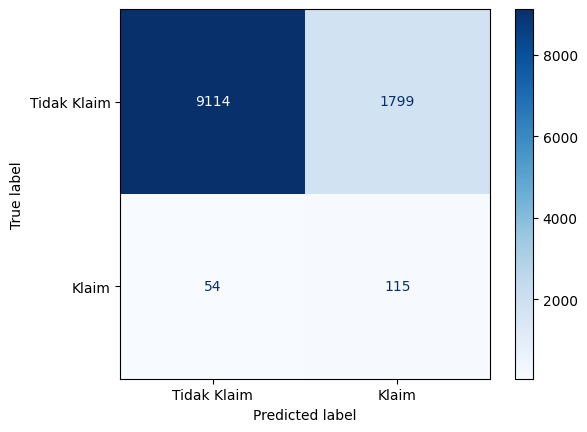

In [173]:
# 1. Definisikan model final dengan parameter terbaik dari GridSearchCV
# Parameter diambil dari hyperparameter tuning pada data train
best_params = {
    'learning_rate': 0.01,
    'max_depth': -1,
    'n_estimators': 200,
    'num_leaves': 31,
    'random_state': 42, # Selalu gunakan random_state untuk konsistensi
    'n_jobs': -1
}

final_lgbm_model = lgb.LGBMClassifier(**best_params)

# 2. Bangun pipeline final dengan model yang sudah di-tuning
final_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('classifier', final_lgbm_model)
])

# 3. Latih pipeline final pada KESELURUHAN data latih
print("--- Melatih model final dengan parameter terbaik ---")
final_pipeline.fit(X_train, y_train)
print("--- Pelatihan model final selesai ---")

# 4. Lakukan prediksi pada data tes (data yang belum pernah dilihat model)
print("\n--- Mengevaluasi model pada data tes ---")
y_pred_final = final_pipeline.predict(X_test)
y_proba_final = final_pipeline.predict_proba(X_test)[:, 1]

# 5. Tampilkan metrik evaluasi final
final_auc = roc_auc_score(y_test, y_proba_final)
print(f"Skor AUC pada Data Tes: {final_auc:.4f}")
print("\nLaporan Klasifikasi Final:")
print(classification_report(y_test, y_pred_final, target_names=['Tidak Klaim (0)', 'Klaim (1)']))

# 6. Tampilkan Confusion Matrix untuk melihat detail kesalahan model
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tidak Klaim', 'Klaim'])
disp.plot(cmap='Blues')
plt.show()

Hasil dari Hyperparameter tuning mengalami peningkatan dibandingkan sebelumnya dari sisi AUC-ROC (0,8032 -> 0,8348), hal ini juga terjadi cukup signifikan pada Recall (51,55% -> 68%) dimana model dapat menangkap lebih luas potensi klaim yang diajukan. Dari sisi precision tidak ditemukan ada perubahan yang signifikan.

# Threshold Tuning

Threshold terbaik berdasarkan F1-Score: 0.7303
  -> F1-Score pada threshold ini: 0.1552
  -> Precision pada threshold ini: 0.0931
  -> Recall pada threshold ini: 0.4675


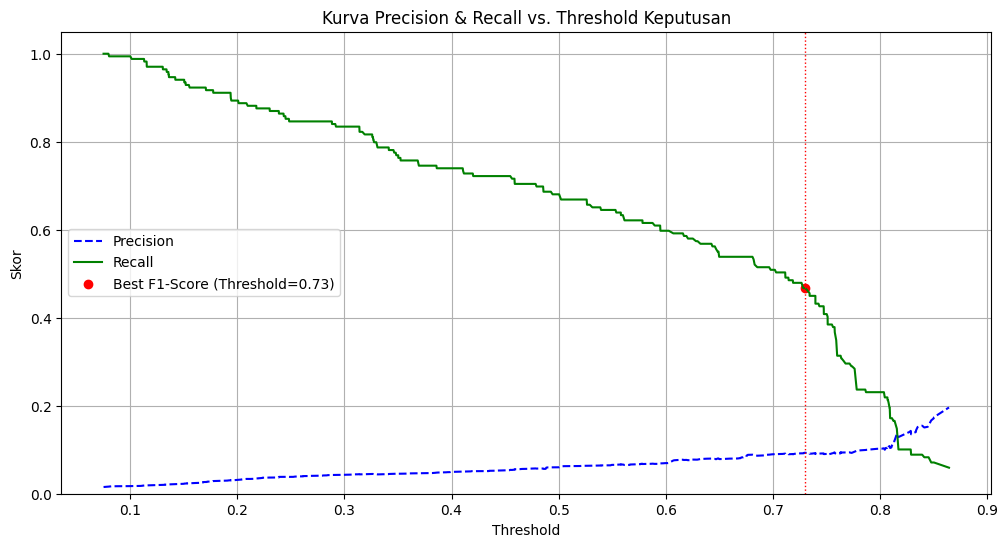

In [171]:
# 1. Hitung precision, recall, dan thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_final)

# 2. Cari threshold yang memberikan F1-Score tertinggi
# Kita perlu menambahkan nilai terakhir ke array F1 agar panjangnya sama dengan precisions/recalls
f1_scores = (2 * precisions * recalls) / (precisions + recalls)
# Mengatasi pembagian dengan nol
f1_scores = np.nan_to_num(f1_scores)

# Dapatkan indeks dari F1-score maksimum
ix = np.argmax(f1_scores)
optimal_threshold = thresholds[ix]
best_f1 = f1_scores[ix]
recall_at_best_f1 = recalls[ix]
precision_at_best_f1 = precisions[ix]

print(f"Threshold terbaik berdasarkan F1-Score: {optimal_threshold:.4f}")
print(f"  -> F1-Score pada threshold ini: {best_f1:.4f}")
print(f"  -> Precision pada threshold ini: {precision_at_best_f1:.4f}")
print(f"  -> Recall pada threshold ini: {recall_at_best_f1:.4f}")


# 3. Membuat visualisasi kurva Precision-Recall vs. Threshold
plt.figure(figsize=(12, 6))
# Plot Precision dan Recall. thresholds memiliki panjang n-1, jadi kita potong array precisions/recalls
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')

# Tandai titik F1-Score terbaik
plt.scatter(optimal_threshold, recall_at_best_f1, marker='o', color='red', label=f'Best F1-Score (Threshold={optimal_threshold:.2f})')
plt.axvline(optimal_threshold, color='red', linestyle=':', lw=1)

# Pengaturan plot
plt.title('Kurva Precision & Recall vs. Threshold Keputusan')
plt.xlabel('Threshold')
plt.ylabel('Skor')
plt.legend()
plt.grid(True)
plt.ylim([0, 1.05])
plt.show()

In [154]:
# Dapatkan threshold optimal dari langkah sebelumnya
optimal_threshold = 0.7303 # Ganti dengan hasil Anda

# Buat prediksi baru menggunakan threshold yang sudah di-tuning
final_predictions_tuned = (y_proba_final >= optimal_threshold).astype(int)

# Lihat laporan klasifikasi yang baru
print("Laporan Klasifikasi dengan Threshold Default (0.5):")
# y_pred_final adalah prediksi lama dengan threshold 0.5
print(classification_report(y_test, y_pred_final, target_names=['Tidak Klaim', 'Klaim']))

print("\nLaporan Klasifikasi dengan Threshold Optimal (" + str(round(optimal_threshold, 2)) + "):")
print(classification_report(y_test, final_predictions_tuned, target_names=['Tidak Klaim', 'Klaim']))

Laporan Klasifikasi dengan Threshold Default (0.5):
              precision    recall  f1-score   support

 Tidak Klaim       0.99      0.84      0.91     10913
       Klaim       0.06      0.68      0.11       169

    accuracy                           0.83     11082
   macro avg       0.53      0.76      0.51     11082
weighted avg       0.98      0.83      0.90     11082


Laporan Klasifikasi dengan Threshold Optimal (0.73):
              precision    recall  f1-score   support

 Tidak Klaim       0.99      0.93      0.96     10913
       Klaim       0.09      0.47      0.16       169

    accuracy                           0.92     11082
   macro avg       0.54      0.70      0.56     11082
weighted avg       0.98      0.92      0.95     11082



Dari hasil threshold tunning, diambil beberapa informasi sebagai berikut:

- meningkatkan nilai threshold, akan meningkatkan nilai precision, tetapi disisi lain akan mengurangi nilai recall. Dimana berarti akan menimbulkan potensi claim yang terlewatkan. Apabila fokus perusahaan adalah efisiensi sumber daya, karena proses claim membutuhkan sumber daya yang besar, maka memperbesar nilai threshold menjadi salah satu rekomendasi yang bisa dilakukan.

- menurunkan nilai threshold, akan meningkatkan nilai recall, tetapi disisi lain akan mengurangi nilai precision. Dimana berarti akan model berpotensi memberikan alarm palsu lebih banyak. Apabila fokus perusahaan adalah mengurangi jumlah claim yang terlewat dan sumber daya bukan menjadi faktor utama dalam pengambilan keputusan, maka memperkecil nilai threshold menjadi salah satu rekomendasi yang bisa dilakukan

# Features Importance

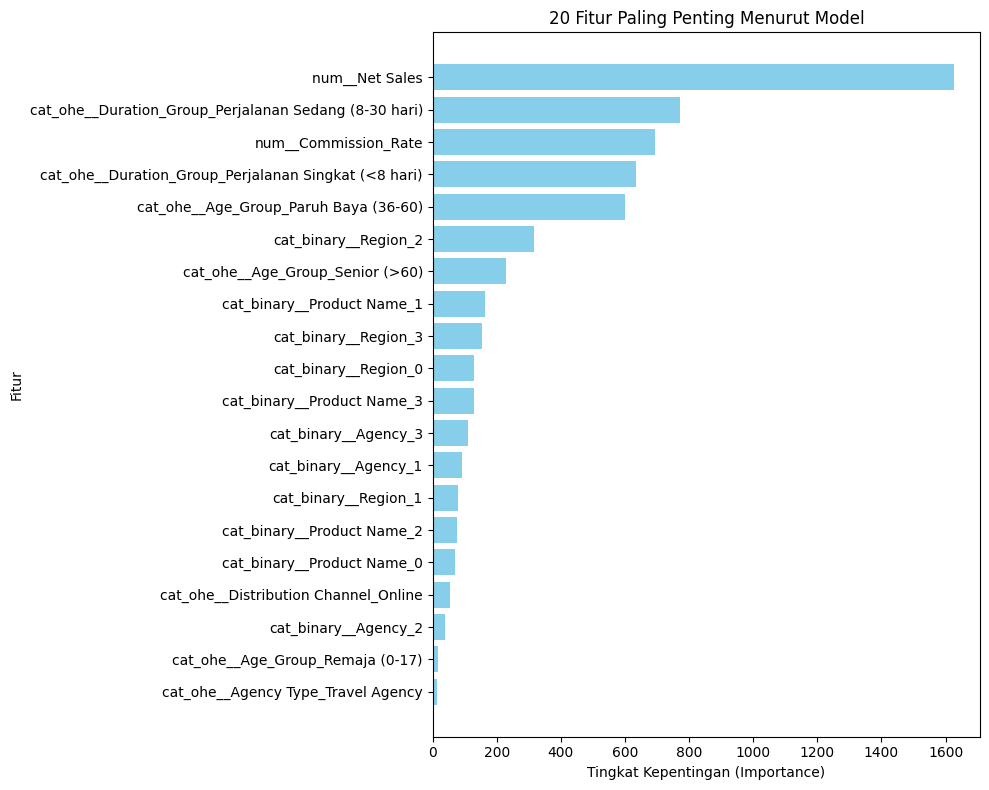

In [169]:
# 1. Mengakses model dan preprocessor dari pipeline
final_model = final_pipeline.named_steps['classifier']
preprocessor = final_pipeline.named_steps['preprocessor']

# 2. Mendapatkan nama fitur secara otomatis dari preprocessor
try:
    all_feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    # Fallback untuk versi sklearn yang lebih lama, meskipun kasus Anda sepertinya lebih baru
    # (Anda bisa menghapus blok try-except ini jika yakin versi sklearn > 1.0)
    numeric_feature_names = preprocessor.named_transformers_['num'].get_feature_names_out()
    categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out()
    all_feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])


# 3. Membuat DataFrame untuk Feature Importance
importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': final_model.feature_importances_
})

# 4. Mengurutkan fitur dari yang paling penting dan mengambil 20 teratas
top_20_features = importance_df.sort_values(by='importance', ascending=False).head(20)

# 5. Membuat visualisasi
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['feature'], top_20_features['importance'], color='skyblue')
plt.xlabel('Tingkat Kepentingan (Importance)')
plt.ylabel('Fitur')
plt.title('20 Fitur Paling Penting Menurut Model')
plt.gca().invert_yaxis()  # Balik urutan agar yang terpenting ada di paling atas
plt.tight_layout()
plt.show()

# Save Model (Pickle)

In [165]:
# Tentukan nama file untuk menyimpan model
filename = 'Capstone3_Yosua.pkl'

# Buka file dalam mode 'write binary' (wb) dan simpan model
with open(filename, 'wb') as file:
    pickle.dump(final_pipeline, file)

print(f"Model berhasil disimpan ke dalam file: {filename}")

Model berhasil disimpan ke dalam file: Capstone3_Yosua.pkl


In [166]:
# Tentukan nama file yang akan dimuat
filename = 'Capstone3_Yosua.pkl'

# Buka file dalam mode 'read binary' (rb) dan muat model
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)

print("Model berhasil dimuat dari file.")

# Sekarang Anda bisa menggunakan 'loaded_model' untuk prediksi
# contoh:
# hasil = loaded_model.predict(data_baru)

Model berhasil dimuat dari file.


In [167]:
# Setiap nilai dimasukkan ke dalam list, meskipun hanya ada satu baris data.
data_to_predict = pd.DataFrame({
    'Agency': ['EPX'],
    'Agency Type': ['Travel Agency'],
    'Distribution Channel': ['Online'],
    'Product Name': ['Cancellation Plan'],
    'Net Sales': [18.0],
    'Region': ['Southeast Asia'],
    'Age_Group': ['Dewasa (18-35)'],
    'Duration_Group': ['Perjalanan Sedang (8-30 hari)'],
    'Commission_Rate': [0.0]
})

print("--- Data Baru yang Akan Diprediksi ---")
print(data_to_predict)


# --- Langkah 2: Lakukan Prediksi Menggunakan Model yang Sudah di-Load ---
prediction_result = loaded_model.predict(data_to_predict)

# Hasilnya berupa array, misal: array([0]). Kita ambil elemen pertamanya dengan [0].
final_prediction = prediction_result[0]


# --- Langkah 3: Interpretasikan Hasil Prediksi ---
print(f"\n--- Hasil Prediksi ---")
if final_prediction == 0:
    print("Prediksi: TIDAK KLAIM")
    print("Rekomendasi: Alokasi dana standar, potensi keuntungan investasi bisa dimaksimalkan.")
else:
    print("Prediksi: BERPOTENSI KLAIM")
    print("Rekomendasi: Perlu menyediakan alokasi dana untuk mengantisipasi klaim dari nasabah ini.")

--- Data Baru yang Akan Diprediksi ---
  Agency    Agency Type Distribution Channel       Product Name  Net Sales  \
0    EPX  Travel Agency               Online  Cancellation Plan       18.0   

           Region       Age_Group                 Duration_Group  \
0  Southeast Asia  Dewasa (18-35)  Perjalanan Sedang (8-30 hari)   

   Commission_Rate  
0              0.0  

--- Hasil Prediksi ---
Prediksi: TIDAK KLAIM
Rekomendasi: Alokasi dana standar, potensi keuntungan investasi bisa dimaksimalkan.


c:\Users\yosua\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# Conclusion and Recommendation

In [162]:
print(classification_report(y_test, y_pred_final, target_names=['Tidak Klaim', 'Klaim']))

              precision    recall  f1-score   support

 Tidak Klaim       0.99      0.84      0.91     10913
       Klaim       0.06      0.68      0.11       169

    accuracy                           0.83     11082
   macro avg       0.53      0.76      0.51     11082
weighted avg       0.98      0.83      0.90     11082



Berdasarkan hasil classification report dari model yang sudah dibangun, kita dapat mengambil kesimpulan bahwa model dapat menangkap 68% polis asuransi yang berpotensi mengajukan claim, disisi lain model dapat menangkap 84% polis asuransi yang tidak memeliki potensi claim. Dari model juga perlu diperhatikan bahwa tingkat presicion dari model sangat rendah, mengindikasikan bahwa model memprediksi pengajuan claim tetapi realisasinya ternyata tidak. Hal tersebut ditunjukan dengan nilai Precision Klaim (6%). Model ini masih perlu didiskusikan dengan para shareholder perusahaan (manajemen perusahaan) untuk menyesuaikan dengan kebutuhan perusahaan.

* Jika fokus perusahaan adalah efisiensi sumber daya, karena proses claim membutuhkan sumber daya yang besar, maka model dapat disesuaikan dengan meningkatkan nilai precision
* Jika fokus perusahaan adalah mengurangi jumlah claim yang terlewat dan sumber daya bukan menjadi faktor utama dalam pengambilan keputusan, maka model dapat disesuaikan dengan meningkatkan nilai recall

Perlu diingat bahwa kondisi secara besaran tingkat claim hanya 1,5% dari keseluruhan polis. Menandakan bahwa data inbalanced, dimana hal ini memerlukan penyesuaian dari jumlah data yang disediakan agar bisa menambahkan lebih banyak data claim.

Ref : `https://apps.bcainsurance.co.id/travel/components/files/RIPLAY_UMUM_-_TRAVEL__COVID__V2.pdf`

Simulasi perhitungan

Jika kita mengasumsikan premi yang dibayarkan ke perusahaan adalah $40 untuk setiap polisnya
Jumlah polis yang masuk adalah 11.082
Rasio premi dengan pemberian claim adalah 1:10 (kita mengeneralisasi sumua potensi claim dari paling kecil ke paling besar)

Kondisi tidak menggunakan Model:
- Semua orang memiliki probabilitas yang sama untuk claim (50:50)
- Potensi claim masuk adalah 5.041
- Nilai claim yang disediakan perusahaan : 5.041 * 10 * 40 = $2.016.400

Kondisi menggunakan model (jumlah polis yang diprediksi claim)
- Jumlah polis yang diprediksi (1.799 + 115) = 1914
- Nilai claim yang disediakan perusahaan 1.914 * 10 * 40 = $ 765.600
- Nilai claim yang direalisasi  115 * 10 * 40 = 46.000
- Nilai claim yang tidak direalisasi 1.799 * 10 * 40 = 719.600

Jika menggunakan model saat ini, berdasarkan simulasi kita berhasil mengurangi jumlah nilai uang yang disediakan oleh perusahaan sebesar 62,1% dibandingkan tanpa penggunaan model. Melalui Efisiensi ini, perusahaan bisa memaksimalkan pendapatan melalui kegiatan investasinya

Rekomendasi yang dapat diberikan untuk pengembangan model lebih lanjut:
- Menambah data claim ke dataset
- Melakukan uji coba ulang model dengan nilai threshold yang baru, keputusan diambil oleh stakeholder perusahaan berdasarkan kebutuhan strategis perusahaan
- Menambahkan fitur baru seperti jenis claim yang diajukan dan nilai claim yang diberikan
- Menganalisa data-data pada kelompok false positif dan false negatif untuk menemukan karakteristik tertentu

Rekomendasi aksi dari sisi perusahaan:
- pengembangan produk dengan informasi yang sudah didapatkan, mengevaluasi produk yang sudah ada atau membuat produk baru untuk mendapatkan struktur premi yang lebih di masa yang akan datang


Good Luck and Thank You